In [ ]:
from pathlib import Path
import os

# Define the base directory explicitly (path to /Birdify/notebooks)
base_dir = Path('/Users/mariaprosgaznares/Desktop/Birdify/notebooks')
print(f"Base directory: {base_dir}\nExists: {base_dir.exists()}\n")

# Data directories
data_dir = base_dir / 'data'
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed'
features_dir = data_dir / 'features'

print(f"Data directory: {data_dir}\nExists: {data_dir.exists()}")
print(f"Raw data directory: {raw_data_dir}\nExists: {raw_data_dir.exists()}")
print(f"Processed data directory: {processed_data_dir}\nExists: {processed_data_dir.exists()}")
print(f"Features directory: {features_dir}\nExists: {features_dir.exists()}\n")

# Path to metadata CSV
metadata_path = raw_data_dir / 'Birds Voice.csv'
print(f"Metadata path: {metadata_path}\nExists: {metadata_path.exists()}\n")

# Path to audio files
audio_files_dir = raw_data_dir / 'Voice of Birds'
print(f"Audio files directory: {audio_files_dir}\nExists: {audio_files_dir.exists()}\n")

# List bird folders if audio directory exists
if audio_files_dir.exists():
    bird_folders = [d for d in audio_files_dir.iterdir() if d.is_dir()]
    print(f"Found {len(bird_folders)} bird folders")
    if bird_folders:
        print("\nFirst few bird folders:")
        for bird_folder in bird_folders[:3]:  # Print first 3 as samples
            print(f"- {bird_folder.name}")
        
        # Check MP3 files in first bird folder
        sample_bird = bird_folders[0]
        mp3_files = list(sample_bird.glob('*.mp3'))
        print(f"\nFound {len(mp3_files)} MP3 files in {sample_bird.name}")
        if mp3_files:
            print("\nFirst few MP3 files:")
            for mp3 in mp3_files[:3]:  # Print first 3 as samples
                print(f"- {mp3.name}")
else:
    print("Warning: Audio files directory not found!")


Starting feature extraction pipeline...
Found 525 processed audio segments


[   INFO   ] FreesoundExtractor: Read metadata
[   INFO   ] FreesoundExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] FreesoundExtractor: Compute audio features
[   INFO   ] On connection Flux::flux → IIR::signal:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] ERBBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] FrameCutter: dropping incomplete frame
[   INFO   ] FreesoundExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] FreesoundExtractor: Read metadata
[   INFO   ] FreesoundExtractor: Compute md5


✅ Successfully extracted features for 525/525 files
💾 Saved to: /Users/mariaprosgaznares/Desktop/Birdify/data/features/bird_features.csv

Feature analysis:
Total samples: 525
Unique labels: 11
Features extracted: 194


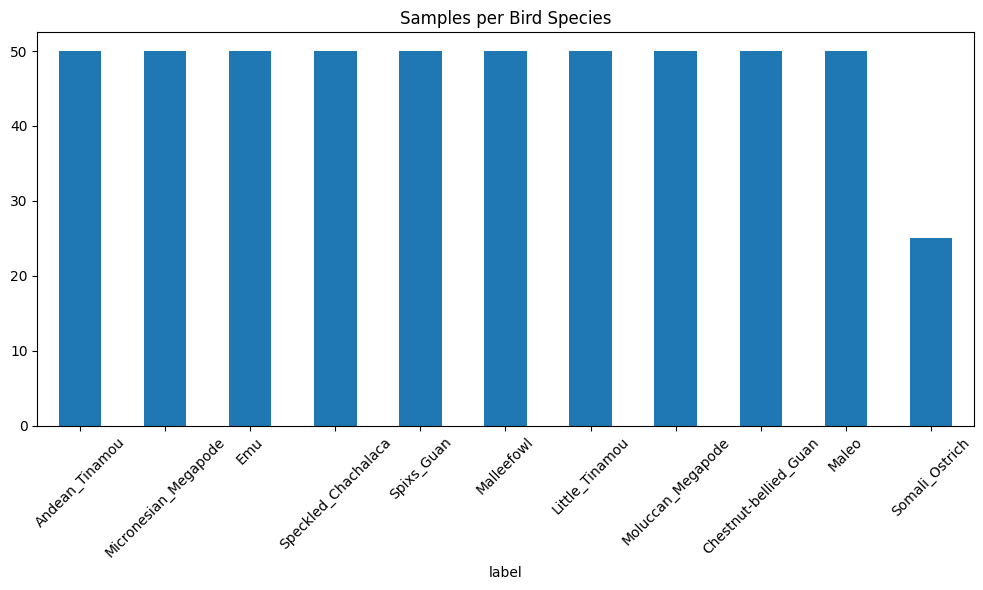

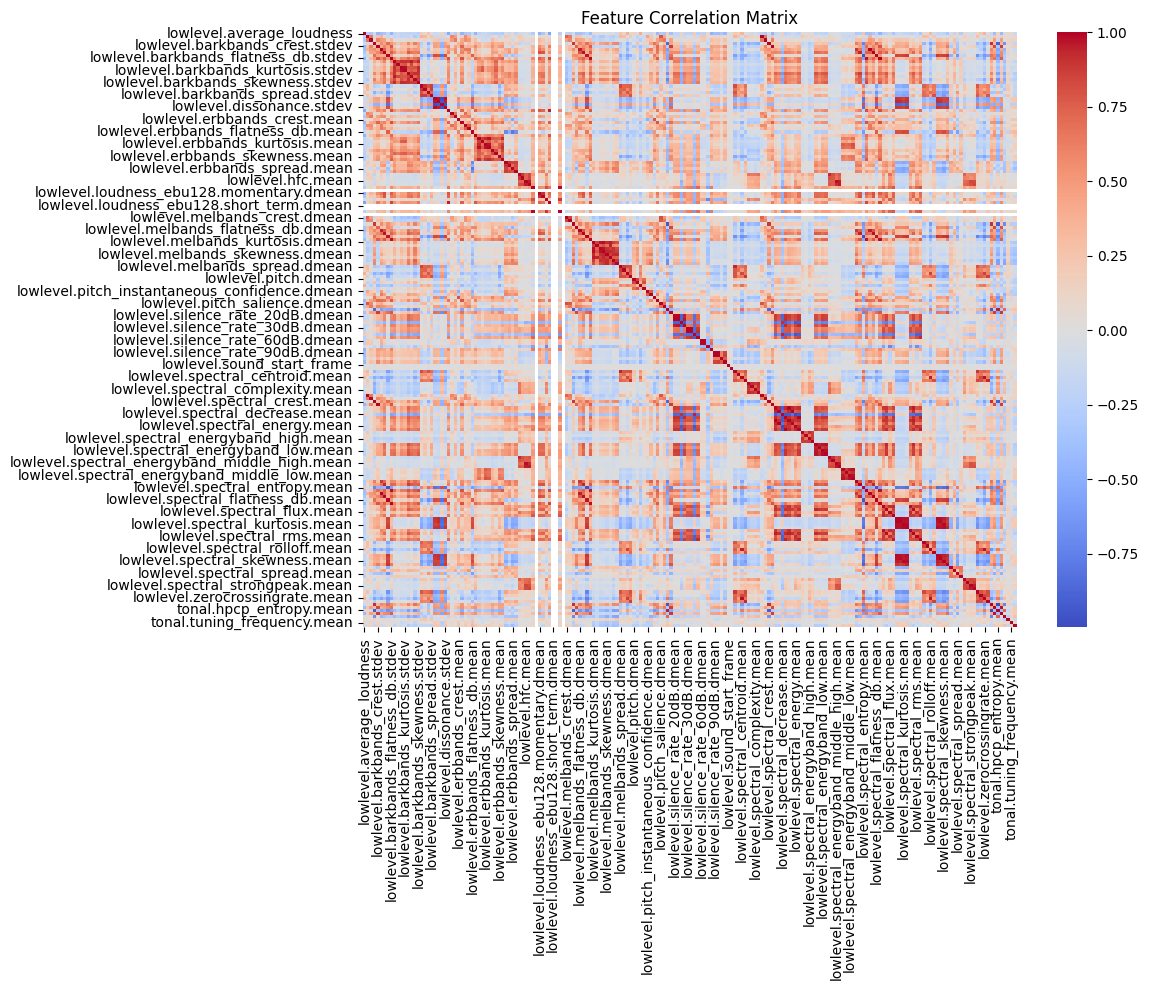

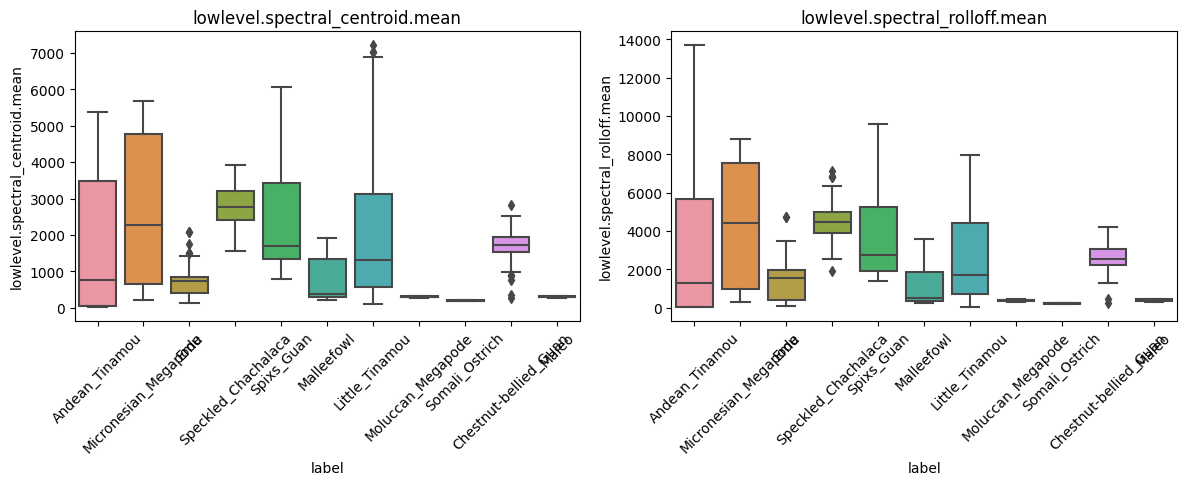


Pipeline completed! Ready for model training.


In [ ]:
import os
import essentia.standard as ess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Configuration
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed' / 'birdcall_segments_3s'
FEATURES_DIR = DATA_DIR / 'features'
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

def load_processed_files(processed_dir):
    """Load all processed WAV files with their labels"""
    segment_files = []
    for wav_file in processed_dir.glob("*.wav"):
        try:
            # Handle both "BirdName_001.wav" and "BirdName_001_processed.wav" formats
            stem_parts = wav_file.stem.split('_')
            label = '_'.join(stem_parts[:-1]) if stem_parts[-1].isdigit() else stem_parts[0]
            segment_files.append({"path": str(wav_file), "label": label})
        except Exception as e:
            print(f"Error processing {wav_file.name}: {e}")
    
    if not segment_files:
        raise ValueError("No processed WAV files found in the directory!")
    
    print(f"Found {len(segment_files)} processed audio segments")
    return segment_files

def initialize_extractor():
    """Create and configure feature extractor with optimal settings"""
    return ess.FreesoundExtractor(
        lowlevelStats=["mean", "stdev", "dmean", "dvar"],
        tonalStats=["mean", "stdev"],
        mfccStats=["mean", "stdev"],
        gfccStats=["mean", "stdev"],
        lowlevelFrameSize=4096,
        lowlevelHopSize=2048,
        lowlevelSilentFrames="drop"
    )

def get_feature_names(extractor, sample_file):
    """Get relevant feature names with proper filtering"""
    sample_features, _ = extractor(sample_file)
    feature_names = []
    
    # Include only numeric features (exclude arrays and silent frames info)
    for desc in sample_features.descriptorNames():
        if (any(x in desc for x in ["lowlevel", "mfcc", "gfcc", "tonal"])
            and isinstance(sample_features[desc], (float, int))):
            feature_names.append(desc)
    
    return sorted(feature_names)

def extract_features(segment_files, output_csv):
    """Robust feature extraction with error handling"""
    extractor = initialize_extractor()
    
    # Get feature names from first successful file
    sample_file = None
    for item in segment_files:
        try:
            _, _ = extractor(item["path"])
            sample_file = item["path"]
            break
        except Exception:
            continue
    
    if not sample_file:
        raise RuntimeError("Could not find a valid file to determine feature names")
    
    feature_names = get_feature_names(extractor, sample_file)
    features_data = []
    failed_files = []
    
    for item in tqdm(segment_files, desc="Extracting features"):
        try:
            features, _ = extractor(item["path"])
            row = {name: features[name] for name in feature_names}
            row["label"] = item["label"]
            row["source_file"] = Path(item["path"]).name
            features_data.append(row)
        except Exception as e:
            failed_files.append((item["path"], str(e)))
    
    if failed_files:
        print(f"\nFailed to process {len(failed_files)} files:")
        for path, error in failed_files[:5]:  # Show first 5 errors
            print(f"- {Path(path).name}: {error}")
        if len(failed_files) > 5:
            print(f"(and {len(failed_files)-5} more)")
    
    features_df = pd.DataFrame(features_data)
    
    # Save with versioning
    version = 1
    while output_csv.exists():
        output_csv = output_csv.parent / f"{output_csv.stem}_v{version}{output_csv.suffix}"
        version += 1
    
    features_df.to_csv(output_csv, index=False)
    return features_df

def analyze_features(features_df):
    """Generate useful visualizations of the extracted features"""
    print("\nFeature analysis:")
    print(f"Total samples: {len(features_df)}")
    print(f"Unique labels: {features_df['label'].nunique()}")
    print(f"Features extracted: {len(features_df.columns) - 2}")  # excluding label and source_file
    
    # Label distribution
    plt.figure(figsize=(10, 6))
    features_df['label'].value_counts().plot(kind='bar')
    plt.title("Samples per Bird Species")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Feature correlations
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 10))
        sns.heatmap(features_df[numeric_cols].corr(), cmap='coolwarm', center=0)
        plt.title("Feature Correlation Matrix")
        plt.tight_layout()
        plt.show()
    
    # Important feature distributions
    important_features = [
        'lowlevel.mfcc.mean',
        'lowlevel.spectral_centroid.mean',
        'lowlevel.spectral_contrast.mean',
        'lowlevel.spectral_rolloff.mean'
    ]
    
    available_features = [f for f in important_features if f in features_df.columns]
    if available_features:
        plt.figure(figsize=(12, 8))
        for i, feature in enumerate(available_features[:4], 1):
            plt.subplot(2, 2, i)
            sns.boxplot(data=features_df, x='label', y=feature)
            plt.xticks(rotation=45)
            plt.title(feature)
        plt.tight_layout()
        plt.show()

def main():
    print("Starting feature extraction pipeline...")
    
    # Step 1: Load processed files
    try:
        segment_files = load_processed_files(PROCESSED_DATA_DIR)
    except Exception as e:
        print(f"Error loading processed files: {e}")
        return
    
    # Step 2: Extract features
    features_csv = FEATURES_DIR / 'bird_features.csv'
    try:
        features_df = extract_features(segment_files, features_csv)
        print(f"\n✅ Successfully extracted features for {len(features_df)}/{len(segment_files)} files")
        print(f"💾 Saved to: {features_csv}")
    except Exception as e:
        print(f"❌ Feature extraction failed: {e}")
        return
    
    # Step 3: Analyze features
    try:
        analyze_features(features_df)
    except Exception as e:
        print(f"⚠️ Feature analysis failed: {e}")
    
    print("\nPipeline completed! Ready for model training.")

if __name__ == "__main__":
    main()

lowlevel.average_loudness         float64
lowlevel.barkbands_crest.dmean    float64
lowlevel.barkbands_crest.dvar     float64
lowlevel.barkbands_crest.mean     float64
lowlevel.barkbands_crest.stdev    float64
                                   ...   
tonal.hpcp_entropy.stdev          float64
tonal.hpcp_peak_count             float64
tonal.key.strength                float64
tonal.tuning_frequency.mean       float64
tonal.tuning_frequency.stdev      float64
Length: 194, dtype: object


Processing audio files: 100%|██████████| 525/525 [02:35<00:00,  3.38it/s] 



Successfully loaded 525/525 samples
Class distribution: {'Andean_Tinamou': 50, 'Chestnut-bellied_Guan': 50, 'Emu': 50, 'Little_Tinamou': 50, 'Maleo': 50, 'Malleefowl': 50, 'Micronesian_Megapode': 50, 'Moluccan_Megapode': 50, 'Somali_Ostrich': 25, 'Speckled_Chachalaca': 50, 'Spixs_Guan': 50}


2025-05-02 23:45:05.745295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 23:45:05.747433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-02 23:45:05.748920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 audio_input (InputLayer)       [(None, 128, 259, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 259, 32  320         ['audio_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 259, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

2025-05-02 23:45:06.050775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 23:45:06.052351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-02 23:45:06.053855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2025-05-02 23:45:06.676991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 23:45:06.678567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-02 23:45:06.679761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - ETA: 0s - loss: 2.6017 - accuracy: 0.1976

2025-05-02 23:45:29.242336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 23:45:29.243400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-02 23:45:29.245149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 25s 1s/step - loss: 2.6017 - accuracy: 0.1976 - val_loss: 2.1273 - val_accuracy: 0.4190 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 18s 1s/step - loss: 1.6081 - accuracy: 0.4310 - val_loss: 1.9453 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 1.2445 - accuracy: 0.5548 - val_loss: 1.8133 - val_accuracy: 0.5048 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 18s 1s/step - loss: 1.0772 - accuracy: 0.6262 - val_loss: 1.7031 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 1.0395 - accuracy: 0.6310 - val_loss: 1.6207 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 17s 1s/step - loss: 0.9276 - accuracy: 0.6595 - val_loss: 1.5304 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 26s 2s/step - loss: 0.7982 - accura

2025-05-03 00:28:36.000457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 00:28:36.004820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 00:28:36.008115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 7s 342ms/step

Classification Report:
                       precision    recall  f1-score   support

       Andean_Tinamou       0.82      0.90      0.86        10
Chestnut-bellied_Guan       1.00      0.70      0.82        10
                  Emu       0.91      1.00      0.95        10
       Little_Tinamou       0.91      1.00      0.95        10
                Maleo       0.67      0.60      0.63        10
           Malleefowl       0.89      0.80      0.84        10
 Micronesian_Megapode       1.00      1.00      1.00        10
    Moluccan_Megapode       0.69      0.90      0.78        10
       Somali_Ostrich       1.00      1.00      1.00         5
  Speckled_Chachalaca       0.83      1.00      0.91        10
           Spixs_Guan       0.86      0.60      0.71        10

             accuracy                           0.86       105
            macro avg       0.87      0.86      0.86       105
         weighted avg       0.86      0

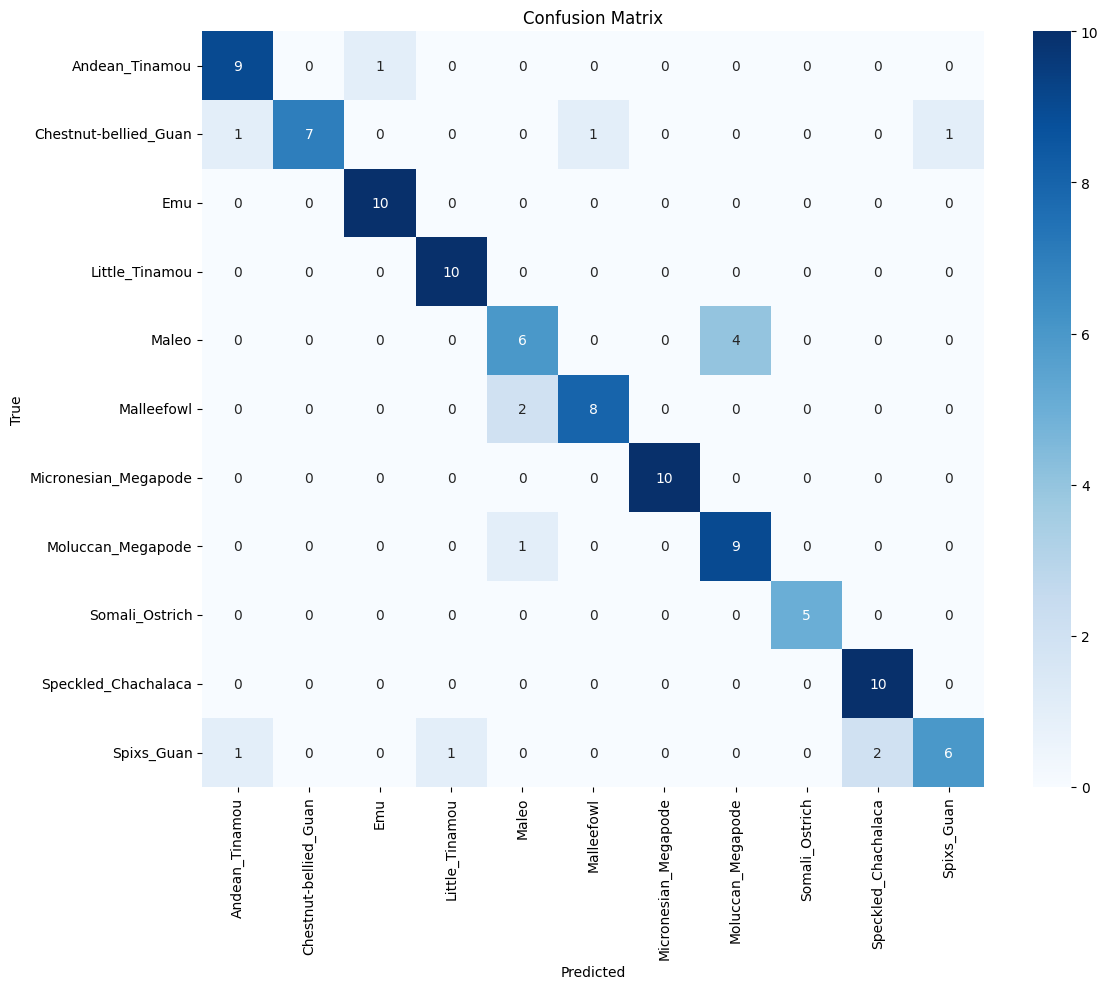

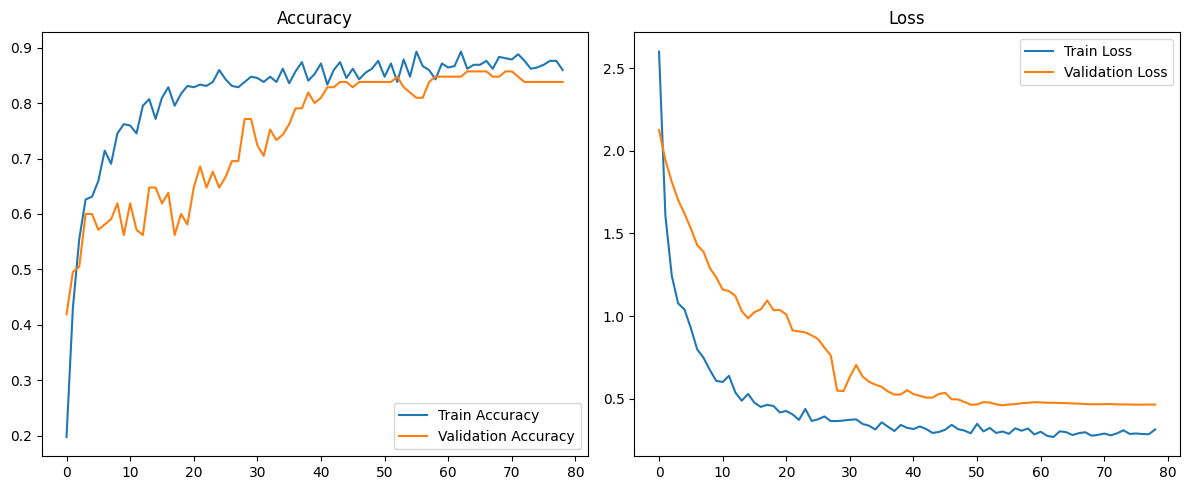

In [6]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuration
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
# Ensure the data directory is correctly referenced from the project root
DATA_DIR = BASE_DIR / 'data'
AUDIO_DIR = DATA_DIR / 'processed' / 'birdcall_segments_3s'
FEATURES_DIR = DATA_DIR / 'features/bird_features.csv'
# Load the extracted features
features_df = pd.read_csv(FEATURES_DIR)

# Audio processing parameters
SAMPLE_RATE = 44100
DURATION = 3  # seconds (matches your 3s segments)
N_MELS = 128  # Number of Mel bands
N_FFT = 2048
HOP_LENGTH = 512
MAX_PAD_LEN = 259  # For 3s audio: (44100 * 3) / 512 ≈ 259

def clean_filename(fname):
    """Standardize filename matching"""
    return os.path.splitext(os.path.basename(fname))[0]

def load_and_preprocess_audio(file_path):
    """Load and preprocess audio into Mel spectrogram"""
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Apply audio augmentation randomly
        if np.random.rand() > 0.5:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))
        if np.random.rand() > 0.5:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
        
        # Create Mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, 
                                         n_fft=N_FFT, hop_length=HOP_LENGTH)
        S_dB = librosa.power_to_db(S, ref=np.max)
        
        # Normalize
        S_dB = (S_dB - np.min(S_dB)) / (np.max(S_dB) - np.min(S_dB))
        
        # Pad or truncate to fixed length
        if S_dB.shape[1] < MAX_PAD_LEN:
            pad_width = MAX_PAD_LEN - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0,0), (0,pad_width)), mode='constant')
        else:
            S_dB = S_dB[:, :MAX_PAD_LEN]
            
        return S_dB[..., np.newaxis]  # Add channel dimension (128, 259, 1)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def create_dataset(features_df):
    """Create dataset from audio files and features"""
    # Get all wav files
    wav_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]
    
    # Identify numeric feature columns (excluding label and source_file)
    numeric_cols = features_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['label', 'source_file']]
    
    # Initialize storage
    X_audio = []
    X_features = []
    y = []
    
    # Initialize label encoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(features_df['label'])
    
    # Initialize feature scaler
    feature_scaler = StandardScaler()
    features = features_df[numeric_cols].values
    feature_scaler.fit(features)
    
    for wav_file in tqdm(wav_files, desc="Processing audio files"):
        file_id = clean_filename(wav_file)
        
        try:
            # Find matching row in features dataframe
            row = features_df[features_df['source_file'].str.contains(file_id)].iloc[0]
            label = row['label']
            
            # Load and preprocess audio
            audio_path = os.path.join(AUDIO_DIR, wav_file)
            spectrogram = load_and_preprocess_audio(audio_path)
            if spectrogram is None:
                continue
                
            # Get and scale features
            features = row[numeric_cols].values.astype(np.float32)
            features = feature_scaler.transform(features.reshape(1, -1))[0]
            
            # Encode label
            label_encoded = label_encoder.transform([label])[0]
            
            # Store data
            X_audio.append(spectrogram)
            X_features.append(features)
            y.append(label_encoded)
            
        except Exception as e:
            print(f"\nError processing {file_id}: {str(e)}")
            continue
    
    print(f"\nSuccessfully loaded {len(y)}/{len(wav_files)} samples")
    print("Class distribution:", dict(zip(label_encoder.classes_, 
                                      np.bincount(y))))
    
    return (
        np.array(X_audio),
        np.array(X_features),
        np.array(y),
        label_encoder
    )

def build_model(audio_shape, n_features, n_classes):
    """Build CNN+LSTM model with feature input"""
    # Audio Input Branch (CNN + LSTM)
    audio_input = Input(shape=audio_shape, name='audio_input')
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(audio_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Prepare for LSTM
    x = layers.Reshape((x.shape[1], -1))(x)  # (time_steps, features)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(32)(x)
    audio_output = layers.Dense(32, activation='relu')(x)

    # Features Input Branch
    features_input = Input(shape=(n_features,), name='features_input')
    f = layers.Dense(64, activation='relu')(features_input)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.2)(f)
    features_output = layers.Dense(32, activation='relu')(f)

    # Combine branches
    merged = layers.concatenate([audio_output, features_output])
    
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.BatchNormalization()(merged)
    merged = layers.Dropout(0.3)(merged)
    
    # Output
    output = layers.Dense(n_classes, activation='softmax')(merged)

    model = Model(
        inputs=[audio_input, features_input],
        outputs=output
    )
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train model with callbacks"""
    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            mode='max',
            restore_best_weights=True
        ),
        ModelCheckpoint(
            'best_birdcall_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            mode='max'
        )
    ]
    
    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluate model and show metrics"""
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred_classes, 
        target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = sns.heatmap(cm, annot=True, fmt='d', 
                      xticklabels=label_encoder.classes_,
                      yticklabels=label_encoder.classes_,
                      cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    # Modify the data loading and preprocessing section:

    # Load the features dataframe
    features_df = pd.read_csv(FEATURES_DIR)

    # Identify numeric columns (excluding label and source_file)
    numeric_cols = features_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['label', 'source_file']]

    # Handle missing values only in numeric columns
    features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].mean())

    # Verify we only have numeric values in feature columns
    print(features_df[numeric_cols].dtypes)

    # Create dataset with only numeric features
    (X_audio, X_features, y, label_encoder) = create_dataset(features_df)
    
    # Split data with stratification
    (X_audio_train, X_audio_test, 
     X_features_train, X_features_test,
     y_train, y_test) = train_test_split(
        X_audio, X_features, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    
    # Build model
    model = build_model(
        audio_shape=X_audio.shape[1:],
        n_features=X_features.shape[1],
        n_classes=len(label_encoder.classes_)
    )
    model.summary()
    
    # Train
    history = train_model(
        model,
        [X_audio_train, X_features_train],
        y_train,
        [X_audio_test, X_features_test],
        y_test
    )
    
    # Evaluate
    evaluate_model(model, [X_audio_test, X_features_test], y_test, label_encoder)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()